### Install Necessary Libraries

In [ ]:
!pip install pandas
!pip install numpy
!pip install PyTDC
!pip install rdkit
!pip install scikit-learn 
!pip install seaborn

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, uniform


### Import Data

In [3]:
from tdc.single_pred import Tox
data = Tox(name = 'hERG_Karim')
split = data.get_split()

print(split)

Found local copy...
Loading...
Done!


{'train':       Drug_ID                                               Drug  Y
0           1  COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...  0
1           2  CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...  0
2           3  N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...  0
3           4  O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...  0
4           5      Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1  0
...       ...                                                ... ..
9407    13437               O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12  0
9408    13438  CN(C)c1ccc2cc(C(=O)N[C@@H](CCCNC(=N)CCl)C(=O)N...  0
9409    13439  CCN(CC)CCCCNc1ncc2c(n1)N(C)C(=O)N(c1c(Cl)c(OC)...  0
9410    13441              Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1  0
9411    13444  CCc1c(O)cc(O)c(C(=O)c2ccc(OCCN3CCOCC3)c(OC)c2)...  0

[9412 rows x 3 columns], 'valid':       Drug_ID                                               Drug  Y
0       10900  CC(C)(C)c1cc(NC(=O)n2ccc3ncc(OC4=NC=N[C@H]5CNC...  0
1  

### Clean Data

In [4]:
# helper function to check SMILE strings from dataset w/ RDKit
def validate_smiles(smiles):
    try:
        # converts SMILES to molecular obj
        mol = Chem.MolFromSmiles(smiles)

        # checks if molecular object is valid and returns true if it is
        return mol is not None

    #else false
    except:
        return False

# helper function to clean the dataset splits
def clean_data(split):
    cleaned_split = {}


    for key, df in split.items():
        # removes dupes
        df = df.drop_duplicates()

        # fills in missing vals w/ median & unknown column
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna('Unknown')

        # removes xtra space if there is any and converts binary column of Y into integers
        df['Drug'] = df['Drug'].astype(str)
        df['Drug'] = df['Drug'].str.strip()
        df['Y'] = df['Y'].astype(int)

        # checks SMILES strs and keep only valid ones that are in RDKit
        df['Valid_SMILES'] = df['Drug'].apply(validate_smiles)
        df = df[df['Valid_SMILES']]
        df = df.drop(columns=['Valid_SMILES'])

        #append cleaned data splits onto list
        cleaned_split[key] = df

    return cleaned_split

#checking cleaned dataset splits
cleaned_split = clean_data(split)
print(cleaned_split)

# checking balance
def check_balance(cleaned_split):
    for key, df in cleaned_split.items():
        print(f"Split: {key}")
        y_distribution = df['Y'].value_counts(normalize=True)
        print(y_distribution)
        if (y_distribution.min() < 0.4) or (y_distribution.max() > 0.6):
            print("unbalanced")
        else:
            print("balanced")

check_balance(cleaned_split)

{'train':       Drug_ID                                               Drug  Y
0           1  COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...  0
1           2  CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...  0
2           3  N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...  0
3           4  O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...  0
4           5      Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1  0
...       ...                                                ... ..
9407    13437               O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12  0
9408    13438  CN(C)c1ccc2cc(C(=O)N[C@@H](CCCNC(=N)CCl)C(=O)N...  0
9409    13439  CCN(CC)CCCCNc1ncc2c(n1)N(C)C(=O)N(c1c(Cl)c(OC)...  0
9410    13441              Cc1cccc(-c2n[nH]cc2-c2ccc3ncccc3n2)n1  0
9411    13444  CCc1c(O)cc(O)c(C(=O)c2ccc(OCCN3CCOCC3)c(OC)c2)...  0

[9412 rows x 3 columns], 'valid':       Drug_ID                                               Drug  Y
0       10900  CC(C)(C)c1cc(NC(=O)n2ccc3ncc(OC4=NC=N[C@H]5CNC...  0
1  

### Selecting Features

In [5]:
# create morgan fingerprints for SMILES using RDKit
def generate_fingerprints(smiles):

    # create molecule from smiles strings
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
      # radius of 2 to check interactions 2 bonds away, 2048 bits is
      #(makes the ifngerprints 2048 bits), could use 1024 bits as well but it lowers f1 score
      fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

      # turns fingerprint into a list of binary numbers
      return list(fp)
    else:
      # no bits for hte ifngerprints if SMILES is invalid
      return [0] * 2048

# FEATURE ENGINEERING on training dataset
train = cleaned_split['train']
# create fingerprints for each molecules in the training dataset
train_fingerprints = train['Drug'].apply(generate_fingerprints).to_list()
# turn fingerprints into a df so the code can run
X_train = pd.DataFrame(train_fingerprints)
# retrieve the Y column of the dataset that has labels (blockers = 1, not a blocker = 0)
y_train = train['Y']

# same thing as above but on the validation dataset
valid = cleaned_split['valid']
valid_fingerprints = valid['Drug'].apply(generate_fingerprints).to_list()
X_valid = pd.DataFrame(valid_fingerprints)
y_valid = valid['Y']

# same thing as above but on the test dataset
test = cleaned_split['test']
test_fingerprints = test['Drug'].apply(generate_fingerprints).to_list()
X_test = pd.DataFrame(test_fingerprints)
y_test = test['Y']

### Ensemble Model + Finetuning Parameters

In [6]:
# models to be inputted into the ensemble model
# excluded SVM bc it took wayyyyyyy too long to run and finetune:(
model1 = GradientBoostingClassifier(random_state=42)
model2 = RandomForestClassifier(random_state=42)
model3 = LogisticRegression(max_iter=1000, random_state=42)
model4 = ExtraTreesClassifier(random_state=42)  
model5 = KNeighborsClassifier()  

# intialize  ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('gb', model1),
        ('rf', model2),
        ('lr', model3),
        ('et', model4),
        ('knn', model5)
    ],
    voting='soft'
)

# parameter distributions for each model and the parameters i want to finetune
param_dist = {
    'gb__n_estimators': randint(50, 1000),
    'gb__learning_rate': uniform(0.001, 0.3),
    'gb__max_depth': randint(3, 10),

    'rf__n_estimators': randint(50, 1000),
    'rf__max_depth': randint(5, 30),

    'lr__C': uniform(0.001, 100),
    
    'et__n_estimators': randint(50, 1000),  
    'et__max_depth': randint(5, 30),       

    'knn__n_neighbors': randint(3, 15)    
}

# randomized search 50 bc 100+ took way too long
random_search = RandomizedSearchCV(
    estimator=ensemble_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# printing out best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# validate the model
y_pred_valid = random_search.best_estimator_.predict(X_valid)
y_pred_proba_valid = random_search.best_estimator_.predict_proba(X_valid)[:, 1]

# print validation scores
print("Validation Results:")
print(classification_report(y_valid, y_pred_valid))
print(f"AUC-ROC: {roc_auc_score(y_valid, y_pred_proba_valid)}")

/Users/hansonhoang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hansonhoang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Best Parameters: {'et__max_depth': 22, 'et__n_estimators': 842, 'gb__learning_rate': 0.11940744004284165, 'gb__max_depth': 8, 'gb__n_estimators': 619, 'knn__n_neighbors': 5, 'lr__C': 57.0071170089365, 'rf__max_depth': 28, 'rf__n_estimators': 675}
Best Score: 0.8861042206382835
Validation Results:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       683
           1       0.84      0.85      0.84       661

    accuracy                           0.85      1344
   macro avg       0.85      0.85      0.85      1344
weighted avg       0.85      0.85      0.85      1344

AUC-ROC: 0.9193488724435889


In [13]:
print(f"Accuracy: {accuracy_score(y_valid, y_pred_valid)}")

Accuracy: 0.8452380952380952


### Final Evaluation with Best Parameters

In [7]:
# updated w/ best parameters from randomizedsearch
model1 = GradientBoostingClassifier(
    learning_rate= 0.11940744004284165,
    max_depth=8,
    n_estimators= 619,
    random_state=42
)
model2 = RandomForestClassifier(
    max_depth=28,
    n_estimators=675,
    random_state=42
)
model3 = LogisticRegression(
    C=57.0071170089365,
    max_iter= 1000,
    random_state=42
)
model4 = ExtraTreesClassifier(
    max_depth= 22,
    n_estimators=842,
    random_state=42
)
model5 = KNeighborsClassifier(
    n_neighbors=5
)

# intialize  the ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('gb', model1),
        ('rf', model2),
        ('lr', model3),
        ('et', model4),
        ('knn', model5)
    ],
    voting='soft'
)

# fit ensemble model to the training data
ensemble_model.fit(X_train, y_train)

# predict on test set
y_pred_test = ensemble_model.predict(X_test)
y_pred_proba_test = ensemble_model.predict_proba(X_test)[:, 1]

# results from test set
print("Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(classification_report(y_test, y_pred_test))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test)}")


Test Results:
Accuracy: 0.8419486798066196
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1346
           1       0.84      0.85      0.84      1343

    accuracy                           0.84      2689
   macro avg       0.84      0.84      0.84      2689
weighted avg       0.84      0.84      0.84      2689

AUC-ROC: 0.9185803555721761


### Visualization of Results

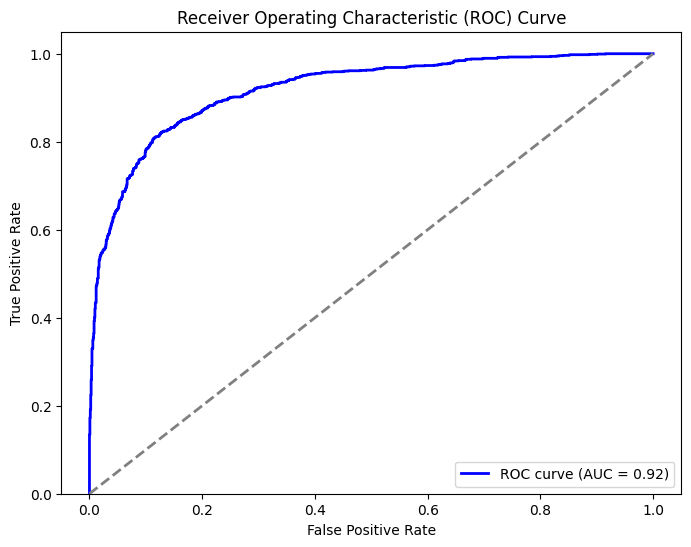

In [8]:
# ROC Curve plot from test dataset

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# generate ROC curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


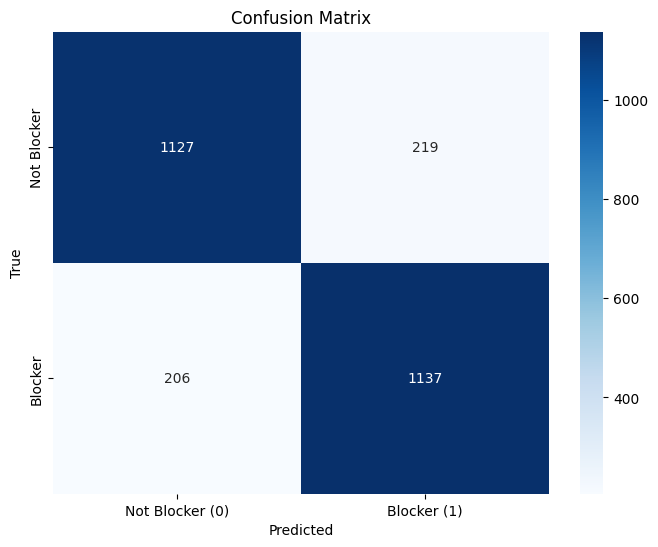

In [9]:
# confusion matrix plot based on test dataset

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Blocker (0)', 'Blocker (1)'], yticklabels=['Not Blocker', 'Blocker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
